In [9]:
import json
import pandas as pd
import seaborn as sns
import re
import pickle
# import mowl
# mowl.init_jvm("4g")
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

## Load depth graph


In [10]:
big_G = {}

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

big_G = read_json_file("../../Data/Output/MeSH_graph_with_depth.json")

print(big_G.nodes["D004628"]["Depth"])

1


## Frequency analysis of MeSH terms in RELISH abstracts

We will load a json file that contains all the MeSH terms that are mentioned in pubmed abstracts

In [11]:
df_TP = pd.DataFrame()
MeSH_cnt = {}

'''
    Function to load a dataset containing the frequency of words and MeSH in RELISH abstracts.
    https://drive.google.com/file/d/1V2jviTCjTq2_qeh4z535P59wr0eCv5ZQ/view?usp=share_link

    Input:  path -> The path location of the json file.
    Output: A DataFrame with "word", "frequency"
'''

def load_Dataset(path):
    global df_TP
    df_TP = pd.read_csv(path,sep='\t')
    df_TP = df_TP.drop(columns=["Unnamed: 0"])
    df_TP.columns = ["word","idf","frequency"]
    print(df_TP.head())

load_Dataset("../../Data/Input/hybridword2vec_all_idf.tsv")

  word     idf  frequency
0  the  388889     0.1680
1   of  370731     0.2158
2  and  244784     0.6309
3   in  377940     0.1965
4   to  307461     0.4029


In [12]:
big_G_nodes = set([x[0] for x in list(big_G.nodes.items())])

for k in big_G_nodes:
    if(k not in MeSH_cnt):
        MeSH_cnt[k] = 0

'''
    Function to sum up the appearances of each individual MeSH term in the RESLISH abstracts.

    Input:  
    Output: A Dictionary with the  count of the appearances of a STY, when an STY appears its parents as well appear   
            {graph_id : CNT} the graph_id is the number representing a MeSH term in the graph representing the ontology.
'''
def count_MeSH_in_Dataset():
    for i in df_TP.index:
        MeSH = str.upper(str(df_TP['word'][i])[4:len(str(df_TP['word'][i]))])
        
        if MeSH in big_G_nodes:
            # print(MeSH)
            MeSH_cnt[MeSH] += int(df_TP['frequency'][i])
            
    #print(sorted(MeSH_cnt.items(), key=lambda kv:(-kv[1], -kv[0])))

count_MeSH_in_Dataset()

In [13]:
nx.set_node_attributes(big_G, MeSH_cnt, "Frequency_Pubmed")
print(big_G.nodes["D000067565"]["Frequency_Pubmed"])

0


In [14]:
with open("../../Data/Output/RELISH_frequency_MeSH_graph_with_depth+freq.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency visualization

    Depth in Mesh Tree  MeSH count
0                    1         258
1                    2        4801
2                    3       12870
3                    4       17668
4                    5       15457
5                    6        9718
6                    7        4210
7                    8        2043
8                    9         956
9                   10         525
10                  11         145
11                  12          69
12                  13          41


[Text(0.5, 1.0, 'MeSH depth frequencies in RELISH abstracts')]

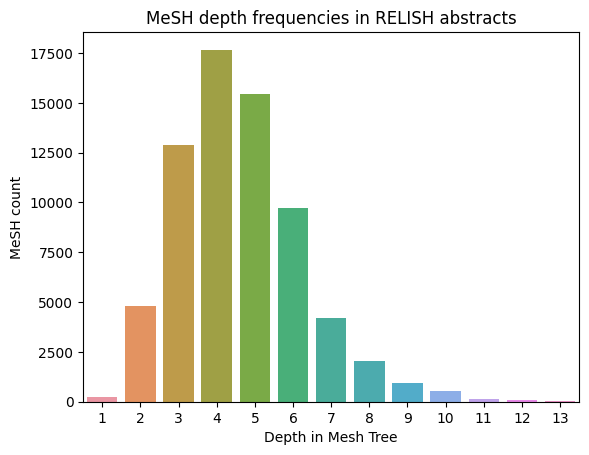

In [15]:
i = 0
Depth_vs_freq = {}
for node_id in big_G.nodes:
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        dpth = big_G.nodes[node_id]["Depth"]
        freq = big_G.nodes[node_id]["Frequency_Pubmed"]
        if(dpth in Depth_vs_freq): Depth_vs_freq[dpth] += freq
        else: Depth_vs_freq[dpth] = freq        
        i+=1
    # if(i == 20): break

sortedKeys = list(Depth_vs_freq.keys())
sortedKeys.sort()
Depth_vs_freq = {i: Depth_vs_freq[i] for i in sortedKeys}

df_Depth_vs_freq = pd.DataFrame()
df_Depth_vs_freq['Depth in Mesh Tree'] = list(Depth_vs_freq.keys())
df_Depth_vs_freq['MeSH count'] = list(Depth_vs_freq.values())

print(df_Depth_vs_freq)
sns.barplot(df_Depth_vs_freq, x="Depth in Mesh Tree", y="MeSH count").set(title='MeSH depth frequencies in RELISH abstracts')

## Addition of depth column to the hybridword2vec_all_idf dataset

The original hybridword2vec_all_idf dataset with a new column regarding 

In [23]:
depths = []
for i in df_TP.index:
    node_id = str.upper(str(df_TP['word'][i])[4:len(str(df_TP['word'][i]))])
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        depths.append(big_G.nodes[node_id]["Depth"])
    else:
        depths.append(-1)

df_TP['Depth'] = depths

df_TP.to_csv("../../Data/Output/hybridword2vec_all_idf+depth.tsv",index=False,sep="\t")

print(df_TP.head(20))
print()   
print("Detph of node meshd012380: ",big_G.nodes["D012380"]["Depth"])       

           word     idf  frequency  Depth
0           the  388889     0.1680     -1
1            of  370731     0.2158     -1
2           and  244784     0.6309     -1
3            in  377940     0.1965     -1
4            to  307461     0.4029     -1
5             a  445648     0.0317     -1
6            is  187264     0.8987     -1
7           for  174439     0.9697     -1
8            by  103204     1.4945     -1
9     catalyzes  131358     1.2533     -1
10         that  104053     1.4863     -1
11  meshd011506   86557     1.6704      2
12           as  177144     0.9543     -1
13         with   97517     1.5512     -1
14     involved   94278     1.5850     -1
15         from   84097     1.6993     -1
16  meshd012380   65290     1.9524      4
17           an  320220     0.3622     -1
18      complex   54105     2.1403     -1
19           it  254851     0.5906     -1

Detph of node meshd012380:  4
